# **1**.   **Data Exploration**





In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed

In [49]:
df = pd.read_csv('../Data/clean_data.csv')

In [50]:
# Check the structure and types of features
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5708 entries, 0 to 5707
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   No                5708 non-null   int64  
 1   Price             5708 non-null   float64
 2   Area              5708 non-null   float64
 3   Bedrooms          5708 non-null   float64
 4   WCs               5708 non-null   float64
 5   Floors            5708 non-null   float64
 6   Legal_status      5708 non-null   float64
 7   Frontage          5708 non-null   float64
 8   Price_per_sqm     5708 non-null   float64
 9   District_encoded  5708 non-null   int64  
 10  Month             5708 non-null   int64  
dtypes: float64(8), int64(3)
memory usage: 490.7 KB
None


In [51]:

# Check basic statistics of numerical features
print(df.describe())

display(df)

             No        Price         Area     Bedrooms          WCs  \
count  5708.000  5708.000000  5708.000000  5708.000000  5708.000000   
mean   2854.500     6.632874    68.305242     3.602488     3.387701   
std    1647.902     3.439563    39.703702     2.039776     1.936481   
min       1.000     0.124000     5.000000     1.000000     1.000000   
25%    1427.750     4.200000    45.000000     2.000000     2.000000   
50%    2854.500     5.695000    60.000000     3.000000     3.000000   
75%    4281.250     8.300000    80.000000     4.000000     4.000000   
max    5708.000    18.000000   525.000000    44.000000    37.000000   

            Floors  Legal_status     Frontage  Price_per_sqm  \
count  5708.000000   5708.000000  5708.000000    5708.000000   
mean      3.047302      0.135599    -0.078486       0.107270   
std       1.001421      0.990851     0.726581       0.052508   
min       1.000000     -1.000000    -1.000000       0.030000   
25%       2.000000     -1.000000    -1.0

,No,Price,Area,Bedrooms,WCs,Floors,Legal_status,Frontage,Price_per_sqm,District_encoded,Month
0,1,13.5,44.00,3.0,3.0,5.0,-1.0,1.0,0.31,0,11
1,2,8.7,45.00,3.0,3.0,4.0,1.0,0.0,0.19,0,11
2,3,9.3,40.00,4.0,4.0,4.0,1.0,0.0,0.23,0,11
3,4,15.0,151.69,5.0,4.0,3.0,-1.0,1.0,0.10,0,10
4,5,16.0,151.69,5.0,4.0,3.0,-1.0,1.0,0.11,0,10
...,...,...,...,...,...,...,...,...,...,...,...
5703,5704,9.5,61.40,4.0,4.0,3.0,-1.0,1.0,0.15,23,1
5704,5705,13.5,104.70,3.0,4.0,4.0,1.0,0.0,0.13,23,1
5705,5706,6.8,68.00,4.0,4.0,3.0,1.0,0.0,0.10,23,1
5706,5707,6.5,62.50,3.0,4.0,2.0,-1.0,-1.0,0.10,23,1


In [52]:
df.drop('No',axis=1,inplace=True)

# **2. Feature Selection/Engineering**

In [53]:
# Tính giá trung bình trên mỗi mét vuông cho mỗi quận
average_pricesqm_per_district = df.groupby('District_encoded')['Price_per_sqm'].mean().reset_index()

# Đổi tên cột để dễ nhận biết
average_pricesqm_per_district.columns = ['District_encoded', 'Average_pricesqm']

In [54]:
# Kết hợp dữ liệu giá trung bình trên mỗi mét vuông vào dataframe chính
df = df.merge(average_pricesqm_per_district, on='District_encoded', how='left')

# Xem dataframe sau khi thêm đặc trưng mới
print(df.head())


   Price    Area  Bedrooms  WCs  Floors  Legal_status  Frontage  \
0   13.5   44.00       3.0  3.0     5.0          -1.0       1.0   
1    8.7   45.00       3.0  3.0     4.0           1.0       0.0   
2    9.3   40.00       4.0  4.0     4.0           1.0       0.0   
3   15.0  151.69       5.0  4.0     3.0          -1.0       1.0   
4   16.0  151.69       5.0  4.0     3.0          -1.0       1.0   

   Price_per_sqm  District_encoded  Month  Average_pricesqm  
0           0.31                 0     11          0.174722  
1           0.19                 0     11          0.174722  
2           0.23                 0     11          0.174722  
3           0.10                 0     10          0.174722  
4           0.11                 0     10          0.174722  


In [55]:
numerical_features = ['Area', 'Bedrooms', 'WCs', 'Floors', 'Price_per_sqm', 'Average_pricesqm']

# Khởi tạo MinMaxScaler
scaler = MinMaxScaler()

# Chuẩn hóa các đặc trưng số
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Mã hóa các đặc trưng phân loại
# Legal_status: 1 (có sổ), -1 (không có thông tin)
# Frontage: 1 (mặt tiền), 0 (hẻm), -1 (không có thông tin)
df['Legal_status_1'] = (df['Legal_status'] == 1).astype(int)
df['Legal_status_missing'] = (df['Legal_status'] == -1).astype(int)

df['Frontage_1'] = (df['Frontage'] == 1).astype(int)
df['Frontage_0'] = (df['Frontage'] == 0).astype(int)
df['Frontage_missing'] = (df['Frontage'] == -1).astype(int)

# Loại bỏ các cột ban đầu của Legal_status và Frontage
df = df.drop(['Legal_status', 'Frontage'], axis=1)

The reason for encoding Legal_status and Frontage into binary indicators is to avoid implying a linear relationship with house prices.

In [56]:
df

,Price,Area,Bedrooms,WCs,Floors,Price_per_sqm,District_encoded,Month,Average_pricesqm,Legal_status_1,Legal_status_missing,Frontage_1,Frontage_0,Frontage_missing
0,13.5,0.075000,0.046512,0.055556,0.571429,0.231405,0,11,0.929908,0,1,1,0,0
1,8.7,0.076923,0.046512,0.055556,0.428571,0.132231,0,11,0.929908,1,0,0,1,0
2,9.3,0.067308,0.069767,0.083333,0.428571,0.165289,0,11,0.929908,1,0,0,1,0
3,15.0,0.282096,0.093023,0.083333,0.285714,0.057851,0,10,0.929908,0,1,1,0,0
4,16.0,0.282096,0.093023,0.083333,0.285714,0.066116,0,10,0.929908,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5703,9.5,0.108462,0.069767,0.083333,0.285714,0.099174,23,1,0.347623,0,1,1,0,0
5704,13.5,0.191731,0.046512,0.083333,0.428571,0.082645,23,1,0.347623,1,0,0,1,0
5705,6.8,0.121154,0.069767,0.083333,0.285714,0.057851,23,1,0.347623,1,0,0,1,0
5706,6.5,0.110577,0.046512,0.083333,0.142857,0.057851,23,1,0.347623,0,1,0,0,1


# **3.   Model Training**

In [57]:

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature      # chỉ số của đặc trưng để chia
        self.threshold = threshold  # ngưỡng để chia đặc trưng
        self.left = left            # cây con bên trái (nhỏ hơn hoặc bằng ngưỡng)
        self.right = right          # cây con bên phải (lớn hơn ngưỡng)
        self.value = value          # giá trị của nút lá (trung bình giá trị y)




In [58]:
import numpy as np

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeRegressor:
    def __init__(self, max_depth=None, random_state=None):
        self.max_depth = max_depth
        self.random_state = random_state
        self.tree_ = None
    
    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.tree_ = self._grow_tree(X, y)
    
    def predict(self, X):
        return np.array([self._predict(inputs, self.tree_) for inputs in X])
    
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if (self.max_depth is not None and depth >= self.max_depth) or len(set(y)) == 1:
            return Node(value=np.mean(y))

        feature_indices = np.random.choice(n_features, n_features, replace=False)
        best_feature, best_threshold = self._best_criteria(X, y, feature_indices)

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices

        if not np.any(left_indices) or not np.any(right_indices):
            return Node(value=np.mean(y))

        left_tree = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._grow_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(best_feature, best_threshold, left_tree, right_tree)

    def _best_criteria(self, X, y, feature_indices):
        best_gain = -1
        split_idx, split_threshold = None, None
        for feature_idx in feature_indices:
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                gain = self._information_gain(y, X[:, feature_idx], threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature_idx
                    split_threshold = threshold
        return split_idx, split_threshold

    def _information_gain(self, y, feature_values, threshold):
        parent_loss = self._mse(y)
        left_indices = feature_values <= threshold
        right_indices = ~left_indices
        if not np.any(left_indices) or not np.any(right_indices):
            return 0
        left_loss = self._mse(y[left_indices])
        right_loss = self._mse(y[right_indices])
        n = len(y)
        n_left = len(y[left_indices])
        n_right = len(y[right_indices])
        child_loss = (n_left / n) * left_loss + (n_right / n) * right_loss
        return parent_loss - child_loss

    def _mse(self, y):
        return np.mean((y - np.mean(y)) ** 2)

    def _predict(self, inputs, node):
        while node.left:
            if inputs[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value


In [59]:
class RandomForestRegressor:
    def __init__(self, n_estimators=100, max_depth=None, max_features='sqrt', random_state=None, n_jobs=-1):
        """
        Khởi tạo mô hình RandomForestRegressor.

        Tham số:
        - n_estimators (int): Số lượng cây quyết định trong rừng.
        - max_depth (int): Độ sâu tối đa của mỗi cây quyết định. Nếu None, các cây sẽ được phát triển đầy đủ.
        - max_features (str): Số lượng đặc trưng tối đa được xem xét để phân chia tại mỗi nút.
        - random_state (int): Seed để đảm bảo tính nhất quán của random state.
        - n_jobs (int): Số lượng công việc song song hóa.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators = []
    
    def _bootstrap_sample(self, X, y):
        """
        Tạo một mẫu bootstrap từ dữ liệu gốc.

        Tham số:
        - X (numpy array, shape = [n_samples, n_features]): Dữ liệu đầu vào.
        - y (numpy array, shape = [n_samples]): Nhãn của dữ liệu huấn luyện.

        Returns:
        - X_sample (numpy array, shape = [n_samples, n_features]): Mẫu bootstrap của dữ liệu đầu vào.
        - y_sample (numpy array, shape = [n_samples]): Nhãn của mẫu bootstrap.
        """
        n_samples = len(X)
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]
    
    def fit(self, X, y):
        """
        Huấn luyện mô hình RandomForest dựa trên dữ liệu huấn luyện.

        Tham số:
        - X (numpy array, shape = [n_samples, n_features]): Dữ liệu đầu vào.
        - y (numpy array, shape = [n_samples]): Nhãn của dữ liệu huấn luyện.
        """
        np.random.seed(self.random_state)
        def _fit_single_tree(random_state):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=random_state)
            tree.fit(X_sample, y_sample)
            return tree
        
        random_states = np.random.randint(0, 10000, size=self.n_estimators)
        self.estimators = Parallel(n_jobs=self.n_jobs)(delayed(_fit_single_tree)(rs) for rs in random_states)
    
    def predict(self, X):
        """
        Dự đoán giá trị cho dữ liệu đầu vào mới.

        Tham số:
        - X (numpy array, shape = [n_samples, n_features]): Dữ liệu đầu vào cần dự đoán.

        Returns:
        - predictions (numpy array, shape = [n_samples]): Giá trị dự đoán tương ứng với mỗi mẫu đầu vào.
        """
        all_predictions = np.zeros((len(X), self.n_estimators))
        for i, tree in enumerate(self.estimators):
            all_predictions[:, i] = tree.predict(X)
        return np.mean(all_predictions, axis=1)

# Định nghĩa lại lớp DecisionTreeRegressor của bạn
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeRegressor:
    def __init__(self, max_depth=None, random_state=None):
        self.max_depth = max_depth
        self.random_state = random_state
        self.tree_ = None
    
    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.tree_ = self._grow_tree(X, y)
    
    def predict(self, X):
        return np.array([self._predict(inputs, self.tree_) for inputs in X])
    
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if (self.max_depth is not None and depth >= self.max_depth) or len(set(y)) == 1:
            return Node(value=np.mean(y))

        feature_indices = np.random.choice(n_features, n_features, replace=False)
        best_feature, best_threshold = self._best_criteria(X, y, feature_indices)

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices

        if not np.any(left_indices) or not np.any(right_indices):
            return Node(value=np.mean(y))

        left_tree = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._grow_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(best_feature, best_threshold, left_tree, right_tree)

    def _best_criteria(self, X, y, feature_indices):
        best_gain = -1
        split_idx, split_threshold = None, None
        for feature_idx in feature_indices:
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                gain = self._information_gain(y, X[:, feature_idx], threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature_idx
                    split_threshold = threshold
        return split_idx, split_threshold

    def _information_gain(self, y, feature_values, threshold):
        parent_loss = self._mse(y)
        left_indices = feature_values <= threshold
        right_indices = ~left_indices
        if not np.any(left_indices) or not np.any(right_indices):
            return 0
        left_loss = self._mse(y[left_indices])
        right_loss = self._mse(y[right_indices])
        n = len(y)
        n_left = len(y[left_indices])
        n_right = len(y[right_indices])
        child_loss = (n_left / n) * left_loss + (n_right / n) * right_loss
        return parent_loss - child_loss

    def _mse(self, y):
        return np.mean((y - np.mean(y)) ** 2)

    def _predict(self, inputs, node):
        while node.left:
            if inputs[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value


In [60]:
# Chia tập thành các biến đặc trưng (X) và biến mục tiêu (Y)
X = df.drop('Price', axis=1)  # Đặc trưng
Y = df['Price']  # Biến mục tiêu

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [61]:
"""
    Tìm kiếm trên lưới để tối ưu hóa độ sâu  trong mô hình hồi quy.

    Tham số:
    - X_train (numpy array): Dữ liệu huấn luyện (features).
    - y_train (numpy array): Nhãn của dữ liệu huấn luyện.
    - X_test (numpy array): Dữ liệu kiểm tra (features).
    - y_test (numpy array): Nhãn của dữ liệu kiểm tra.
    - max_depths (list): Danh sách các giá trị độ sâu để thử nghiệm.

    Returns:
    - best_depth (int): Độ sâu tối ưu.
    - best_mse (float): Giá trị MSE tối ưu tương ứng với độ sâu tối ưu.
"""

def simple_grid_search_decision_tree(X_train, y_train, X_test, y_test, max_depths):
    
    best_depth = None
    best_mse = float('inf')

    for depth in max_depths:
        model = DecisionTreeRegressor(max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        if mse < best_mse:
            best_mse = mse
            best_depth = depth

    return best_depth, best_mse


def simple_grid_search_random_forest(X_train, y_train, X_test, y_test, max_depths):

    best_depth = None
    best_mse = float('inf')

    for depth in max_depths:
        model = RandomForestRegressor(max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        if mse < best_mse:
            best_mse = mse
            best_depth = depth

    return best_depth, best_mse



##### The following code snippet has been executed successfully, determining the max_depth for the decision tree as 20 and for the random forest as 10. Due to time constraints, it has been decided not to rerun this code snippet and to apply these two values directly.

*#Tìm giá trị max_depth tốt nhất*  
*max_depths = [None, 10, 20, 30, 40, 50]*
*best_depth_dt, best_mse_dt = simple_grid_search_decision_tree(X_train, y_train, X_test, y_test, max_depths)*  
*print(f"Best max_depth for DecisionTree: {best_depth_dt}, Best MSE: {best_mse_dt}")*  
*best_depth_rf, best_mse_rf = simple_grid_search_random_forest(X_train, y_train, X_test, y_test, max_depths)*  
*print(f"Best max_depth for RandomForest: {best_depth_rf}, Best MSE: {best_mse_rf}")*


In [62]:
#Tìm giá trị max_depth tốt nhất
max_depths = [None, 10, 20, 30, 40, 50]
best_depth_dt, best_mse_dt = simple_grid_search_decision_tree(X_train.values, Y_train.values, X_test.values, Y_test.values, max_depths)
print(f"Best max_depth for DecisionTree: {best_depth_dt}, Best MSE: {best_mse_dt}")


Best max_depth for DecisionTree: 20, Best MSE: 0.4021893388791593


In [63]:
best_depth_rf, best_mse_rf = simple_grid_search_random_forest(X_train.values, Y_train.values, X_test.values, Y_test.values, max_depths)
print(f"Best max_depth for RandomForest: {best_depth_rf}, Best MSE: {best_mse_rf}")

Best max_depth for RandomForest: 10, Best MSE: 0.1843972852828933


In [64]:
# Sử dụng DecisionTree bạn đã định nghĩa để huấn luyện mô hình
tree = DecisionTreeRegressor(max_depth=20, random_state=42)
tree.fit(X_train.values, Y_train.values)

# Dự đoán trên tập kiểm tra
Y_pred_tree = tree.predict(X_test.values)

# Đánh giá hiệu suất của mô hình

print("Decision Tree Regression - MSE:", mean_squared_error(Y_test.values, Y_pred_tree))
print("Decision Tree Regression - MAE:", mean_absolute_error(Y_test.values, Y_pred_tree))
print("Decision Tree Regression - R^2:", r2_score(Y_test.values, Y_pred_tree))


Decision Tree Regression - MSE: 0.4021893388791593
Decision Tree Regression - MAE: 0.32556479859894916
Decision Tree Regression - R^2: 0.964940844628016


In [70]:
# Huấn luyện mô hình Random Forest
random_forest = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
random_forest.fit(X_train.values, Y_train.values)  # Huấn luyện trên tập huấn luyện

# Dự đoán giá nhà trên tập kiểm tra
Y_pred_forest = random_forest.predict(X_test.values)

# Đánh giá hiệu suất của mô hình

print("Random Forest Regression - MSE:", mean_squared_error(Y_test.values, Y_pred_forest))
print("Random Forest Regression - MAE:", mean_absolute_error(Y_test.values, Y_pred_forest))
print("Random Forest Regression - R^2:", r2_score(Y_test.values, Y_pred_forest))


Random Forest Regression - MSE: 0.19208039428147852
Random Forest Regression - MAE: 0.23447024320179896
Random Forest Regression - R^2: 0.9832562036433053


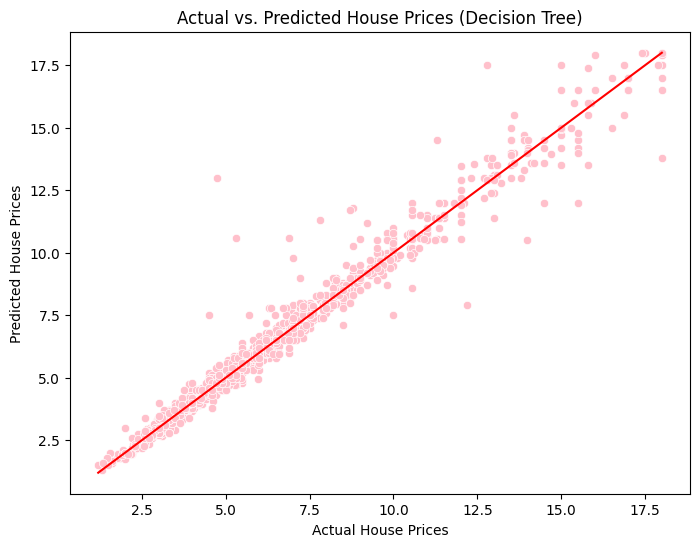

In [71]:
# Assume y_test và rf_y_pred là các giá trị thực và dự đoán tương ứng của Random Forest
# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test, y=Y_pred_tree, color='pink')

# Plot a line for perfect predictions
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', linestyle='-')

plt.title('Actual vs. Predicted House Prices (Decision Tree)')
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.grid(False)
plt.show()


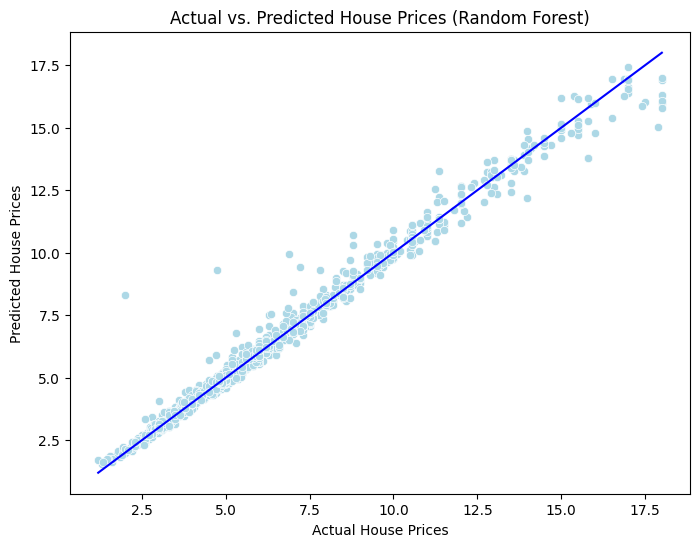

In [72]:
# Assume y_test và rf_y_pred là các giá trị thực và dự đoán tương ứng của Random Forest
# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test, y=Y_pred_forest, color='lightblue')

# Plot a line for perfect predictions
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='blue', linestyle='-')

plt.title('Actual vs. Predicted House Prices (Random Forest)')
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.grid(False)
plt.show()


In [68]:
from sklearn.ensemble import RandomForestRegressor as RFR
# Khởi tạo mô hình Random Forest từ thư viện scikit-learn
sklearn_random_forest = RFR(n_estimators=100, max_depth=None, random_state=42)

# Huấn luyện mô hình trên tập huấn luyện (X_train, Y_train)
sklearn_random_forest.fit(X_train.values, Y_train.values)

# Dự đoán giá nhà trên tập kiểm tra (X_test)
Y_pred_sklearn = sklearn_random_forest.predict(X_test.values)

# Đánh giá hiệu suất của mô hình sử dụng các độ đo
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Random Forest (scikit-learn) - MSE:", mean_squared_error(Y_test.values, Y_pred_sklearn))
print("Random Forest (scikit-learn) - MAE:", mean_absolute_error(Y_test.values, Y_pred_sklearn))
print("Random Forest (scikit-learn) - R^2:", r2_score(Y_test.values, Y_pred_sklearn))


Random Forest (scikit-learn) - MSE: 0.16814038615335689
Random Forest (scikit-learn) - MAE: 0.22728045242265027
Random Forest (scikit-learn) - R^2: 0.9853430726461223


In [69]:

from sklearn.model_selection import GridSearchCV

# Định nghĩa các tham số cần tối ưu
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50]
}

# Tạo đối tượng GridSearchCV
grid_search = GridSearchCV(estimator=sklearn_random_forest, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Huấn luyện mô hình với GridSearchCV
grid_search.fit(X_train.values, Y_train.values)

# In ra max_depth tối ưu
print(f"Best max_depth: {grid_search.best_params_['max_depth']}")
Y_pred_sklearn = sklearn_random_forest.predict(X_test.values)
# Dự đoán và đánh giá trên tập kiểm tra (nếu cần)
print("Random Forest (scikit-learn) - MSE:", mean_squared_error(Y_test.values, Y_pred_sklearn))
print("Random Forest (scikit-learn) - MAE:", mean_absolute_error(Y_test.values, Y_pred_sklearn))
print("Random Forest (scikit-learn) - R^2:", r2_score(Y_test.values, Y_pred_sklearn))


Best max_depth: None
Random Forest (scikit-learn) - MSE: 0.16814038615335689
Random Forest (scikit-learn) - MAE: 0.22728045242265027
Random Forest (scikit-learn) - R^2: 0.9853430726461223


# **Decision Tree**

**1. Tổng quan về Decision Tree**

* Decision Tree (Cây quyết định) là một mô hình học máy phân loại và hồi quy. Mô hình này sử dụng cấu trúc cây, trong đó mỗi nút bên trong đại diện cho một thuộc tính (đặc trưng) và mỗi nhánh đại diện cho một giá trị của thuộc tính đó. Các nút lá thể hiện các giá trị mục tiêu (kết quả). Mô hình cây quyết định có thể được sử dụng cho cả bài toán phân loại và hồi quy.


**2. Lí do chọn mô hình hồi quy**

* Bản chất của biến mục tiêu: Giá nhà là giá trị liên tục, không phải nhãn phân loại.

* Yêu cầu về đầu ra: Cần dự đoán giá trị cụ thể, không phải nhóm giá.

* Phân giải chi tiết hơn: Hồi quy dự đoán giá trị cụ thể với độ chính xác cao hơn.

* Phân loại không phù hợp với giá trị liên tục: Chia giá nhà thành nhóm làm mất thông tin chi tiết.

* Tính chất của mô hình phân loại: Phân loại phù hợp với biến mục tiêu rời rạc, hữu hạn lớp.

=> Hồi quy là lựa chọn tự nhiên và phù hợp cho dự đoán giá trị liên tục như giá nhà.

**3. Cách thức hoạt động của Decision Tree** 

Cây quyết định hoạt động bằng cách chia dữ liệu thành các tập con nhỏ hơn dựa trên các điều kiện. Quá trình chia này tiếp tục lặp lại trên mỗi tập con mới cho đến khi đạt được các điều kiện dừng, chẳng hạn như khi tất cả các điểm dữ liệu trong một nút thuộc về cùng một lớp hoặc khi đạt đến độ sâu tối đa của cây. Các bước cơ bản của việc xây dựng cây quyết định bao gồm:

* Chọn thuộc tính tốt nhất để chia dữ liệu tại mỗi bước. Thuộc tính tốt nhất được chọn dựa trên một tiêu chí, chẳng hạn như thông tin thu được hoặc giảm phương sai.

* Chia dữ liệu thành các tập con dựa trên giá trị của thuộc tính được chọn.

* Lặp lại quá trình trên các tập con cho đến khi đạt được điều kiện dừng.

**4. Ưu điểm và nhược điểm của Decision Tree**
- **Ưu điểm của Decision Tree:**
   + Dễ hiểu và giải thích: Cây quyết định có cấu trúc trực quan dễ dàng để con người hiểu và giải thích.
   + Xử lý tốt dữ liệu không tuyến tính: Cây quyết định không yêu cầu mối quan hệ tuyến tính giữa các thuộc tính và mục tiêu, giúp xử lý tốt dữ liệu phức tạp và không tuyến tính.
   + Có thể xử lý cả dữ liệu phân loại và hồi quy: Cây quyết định có thể áp dụng cho cả hai loại bài toán.

- **Nhược điểm của Decision Tree:**
   + Dễ bị overfitting: Nếu không được cắt tỉa (prune) đúng cách, cây quyết định có thể quá phù hợp với dữ liệu huấn luyện, dẫn đến kém hiệu quả trên dữ liệu mới.
   + Không ổn định: Một thay đổi nhỏ trong dữ liệu có thể dẫn đến một cây quyết định hoàn toàn khác biệt.
   + Thiếu tính liên tục**: Các dự đoán từ cây quyết định thường có tính gián đoạn, không mượt mà như các phương pháp hồi quy.

**5. So sánh với Linear Regression:**
- **Tính đơn giản và dễ hiểu**: Linear Regression cũng dễ hiểu và giải thích nhưng yêu cầu mối quan hệ tuyến tính giữa các thuộc tính và mục tiêu.
- **Khả năng mô hình hóa**: Linear Regression thích hợp hơn cho các dữ liệu có mối quan hệ tuyến tính, trong khi Decision Tree có thể xử lý tốt các mối quan hệ phi tuyến tính.
- **Overfitting**: Linear Regression ít bị overfitting hơn so với Decision Tree nếu dữ liệu có nhiều nhiễu.
- **Hiệu suất**: Linear Regression thường hoạt động tốt trên các dữ liệu có nhiều thuộc tính hơn so với Decision Tree, do cây quyết định có thể gặp vấn đề với dữ liệu có độ chiều cao.

# **Random Forest**

**1. Tổng quan về Random Forest**

* Random Forest là một mô hình học máy mạnh mẽ và linh hoạt, sử dụng nhiều cây quyết định (Decision Trees) để đưa ra dự đoán. Mô hình này kết hợp dự đoán của nhiều cây quyết định để cải thiện độ chính xác và độ ổn định. Random Forest có thể được sử dụng cho cả bài toán phân loại và hồi quy.

**2. Lí do chọn mô hình hồi quy**

* Bản chất của biến mục tiêu: Giá nhà là giá trị liên tục, không phải nhãn phân loại.
* Yêu cầu về đầu ra: Cần dự đoán giá trị cụ thể, không phải nhóm giá.
* Phân giải chi tiết hơn: Hồi quy dự đoán giá trị cụ thể với độ chính xác cao hơn.
* Phân loại không phù hợp với giá trị liên tục: Chia giá nhà thành nhóm làm mất thông tin chi tiết.
* Tính chất của mô hình phân loại: Phân loại phù hợp với biến mục tiêu rời rạc, hữu hạn lớp.

=> Hồi quy là lựa chọn tự nhiên và phù hợp cho dự đoán giá trị liên tục như giá nhà.

**3. Cách thức hoạt động của Random Forest**

Random Forest hoạt động bằng cách xây dựng nhiều cây quyết định trên các mẫu con khác nhau của dữ liệu. Mỗi cây quyết định trong rừng đưa ra dự đoán và Random Forest sẽ lấy trung bình các dự đoán này để đưa ra kết quả cuối cùng. Các bước cơ bản của việc xây dựng Random Forest bao gồm:

* Chọn các mẫu con từ dữ liệu gốc bằng phương pháp lấy mẫu có hoàn lại (bootstrap sampling).
* Xây dựng cây quyết định trên mỗi mẫu con. Tại mỗi nút, chỉ xem xét một tập hợp con ngẫu nhiên các thuộc tính để chia dữ liệu.
* Kết hợp dự đoán của tất cả các cây quyết định bằng cách lấy trung bình (cho bài toán hồi quy) hoặc theo số phiếu bầu (cho bài toán phân loại).

**4. Ưu điểm và nhược điểm của Random Forest**

- **Ưu điểm của Random Forest:**
   + Độ chính xác cao: Sử dụng nhiều cây quyết định giúp cải thiện độ chính xác của mô hình.
   + Giảm thiểu overfitting: Việc kết hợp nhiều cây quyết định giúp giảm thiểu hiện tượng overfitting so với việc sử dụng một cây quyết định duy nhất.
   + Ổn định: Random Forest ít nhạy cảm với các thay đổi nhỏ trong dữ liệu đầu vào.
   + Xử lý tốt dữ liệu không tuyến tính: Random Forest không yêu cầu mối quan hệ tuyến tính giữa các thuộc tính và mục tiêu.

- **Nhược điểm của Random Forest:**
   + Độ phức tạp tính toán: Random Forest yêu cầu nhiều tài nguyên tính toán hơn so với một cây quyết định đơn lẻ.
   + Khả năng diễn giải: Khó diễn giải hơn so với một cây quyết định đơn lẻ do sử dụng nhiều cây.

**5. So sánh với Linear Regression**

- **Tính đơn giản và dễ hiểu:** Linear Regression dễ hiểu và giải thích hơn, nhưng yêu cầu mối quan hệ tuyến tính giữa các thuộc tính và mục tiêu.
- **Khả năng mô hình hóa:** Linear Regression thích hợp hơn cho các dữ liệu có mối quan hệ tuyến tính, trong khi Random Forest có thể xử lý tốt các mối quan hệ phi tuyến tính.
- **Overfitting:** Linear Regression ít bị overfitting hơn so với một cây quyết định đơn lẻ, nhưng Random Forest giảm thiểu được overfitting nhờ kết hợp nhiều cây.
- **Hiệu suất:** Linear Regression hoạt động tốt trên các dữ liệu có nhiều thuộc tính hơn so với một cây quyết định đơn lẻ, nhưng Random Forest có thể xử lý tốt dữ liệu có độ chiều cao.

